# Data & Env Initialization

In [1]:
import os, sys, gc

import zipfile
from os import path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

zip_file = "sample_data/Sky303.zip"
data_path = "sample_data/Sky303/"

if not path.exists(data_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("sample_data/")

input_indice_path = data_path + "input_indices_{}.npy"
input_data_path = data_path + "input_data_{}.npy"
target_path = data_path + "output_indices_{}.npy"

# Constants

In [2]:
N_CONFIGURATIONS = 4262 # number of configuration of the problem
IMG_SHAPE = (1355, 3384, 3)
H, W = 128, 256 # the window size

CAMERA = np.array([[2304.5479, 0,  1686.2379], # the camera matrix
                          [0, 2305.8757, -0.0151],
                          [0, 0, 1.]], dtype=np.float32)

# Data Viz & Utils

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.__version__

'1.3.1+cu92'

In [4]:
class Sky303Dataset(Dataset):
    """Car dataset."""

    def __init__(self):
        super(Sky303Dataset,self).__init__()

    def __len__(self):
        return N_CONFIGURATIONS

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        indice_np = np.load(input_indice_path.format(idx))
        input_np = np.load(input_data_path.format(idx))
        target_np = np.load(target_path.format(idx))
        
        input_bin_mask = np.zeros([H, W, 1], dtype='float16')
        input_bin_mask[indice_np[:,0],indice_np[:,1],:] = 1.
        
        input_2Drepr = np.zeros([H, W, 3], dtype='float16')
        input_2Drepr[indice_np[:,0],indice_np[:,1],:] = input_np
        
        target_2Drepr = np.zeros([H, W, 1], dtype='float16')
        target_2Drepr[target_np[:,0],target_np[:,1],:] = 1.
        
        input_bin_mask = np.rollaxis(input_bin_mask, 2, 0)
        input_bin_mask = torch.from_numpy(input_bin_mask).float()
        
        input_2Drepr = np.rollaxis(input_2Drepr, 2, 0)
        input_2Drepr = torch.from_numpy(input_2Drepr).float()
        
        target_2Drepr = np.rollaxis(target_2Drepr, 2, 0)
        target_2Drepr = torch.from_numpy(target_2Drepr).float()
        
        return [input_bin_mask, input_2Drepr, target_2Drepr]

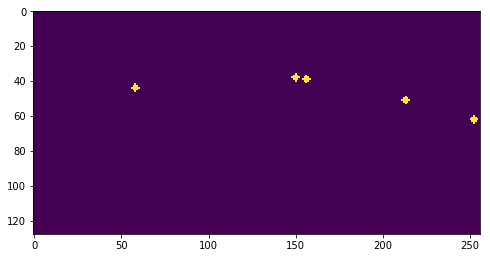

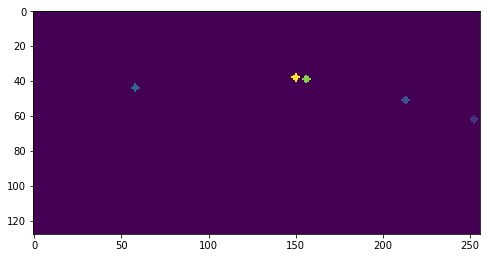

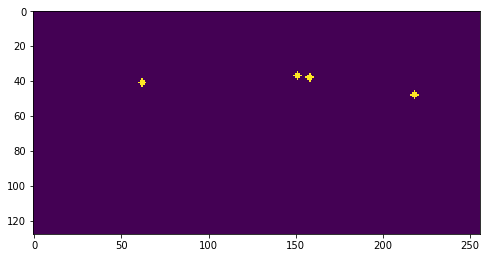

In [5]:
dataset = Sky303Dataset()
input_bin_mask, input_2Drepr, target_2Drepr = dataset[0]

plt.figure(figsize=(8,8))
plt.imshow((input_bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(input_2Drepr.permute(1,2,0).numpy()[:,:,-1]/350.)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow((target_2Drepr.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

# Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# importing the importlib.util module
import importlib.util

# Define the module path
module_path = "../smap/smap.py"

# Load the module using importlib.util
spec = importlib.util.spec_from_file_location("smap", module_path)
smap_module = importlib.util.module_from_spec(spec)
sys.modules["smap"] = smap_module
spec.loader.exec_module(smap_module)

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
class Model(nn.Module):
    def __init__(self, camera_matrix, n=0):
        super(Model,self).__init__()
        self.n = n
        self.camera_matrix = nn.Parameter(torch.from_numpy(camera_matrix), requires_grad=False)
        self.camera_matrix_inv = nn.Parameter(torch.from_numpy(np.linalg.inv(camera_matrix)), requires_grad=False)
        
        self.phi = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.gamma = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.rho = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.theta = nn.Parameter(torch.from_numpy(np.array([0.,-0.,0.])).float().reshape(1,3,1,1), requires_grad=True)
        self.smap_layer = smap_module.SMap(n, camera_matrix)
        
        self.I00 = nn.Parameter(torch.from_numpy(np.array([[1.,.0,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I01 = nn.Parameter(torch.from_numpy(np.array([[0.,1.,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I10 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[1.,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I11 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,1.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I22 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,0.,.0],[.0,.0,1.]])).float().reshape(3,3), requires_grad=False)
        
    def to_3d(self, z, height, width, panels, original_size):
        y_im, x_im = panels
        y_im, x_im = torch.from_numpy(y_im).reshape(height, width), torch.from_numpy(x_im).reshape(height, width)
        y_im = y_im * IMG_SHAPE[0] / original_size[0]
        x_im = x_im * IMG_SHAPE[1] / original_size[1]
        y_im, x_im = y_im.to(device), x_im.to(device)
        
        imp_co = torch.cat([torch.einsum('hw,bczhw->bczhw', x_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.einsum('hw,bczhw->bczhw', y_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.ones_like(z.unsqueeze(2))], 2)
        imp_co = imp_co.reshape(z.size(0),z.size(1),3,height,width)
        imp_co = torch.einsum('bchw,bczhw->bczhw', z.float(), imp_co.float()).reshape(z.size(0),z.size(1),3,-1)
        regr_co = torch.einsum('xz,yz->xy', imp_co.reshape(z.size(0),z.size(1),3,-1).permute(0,1,3,2).reshape(-1,3).float(), self.camera_matrix_inv.float())
        regr_co = regr_co.reshape(z.size(0),z.size(1),-1,3).permute(0,1,3,2).reshape(z.size(0),z.size(1),3,height*width)
        return regr_co
        
    def forward(self, r_x, r_mask, target_2Dr=None, zoom=0):
        mask = r_mask
        
        x = r_x[:,-1:,:,:]
        height, width = x.size(-2), x.size(-1)
        panels = list(np.where(np.ones([height, width])))
        panels[0] = panels[0] + .5
        panels[1] = panels[1] + .5
        
        x = self.to_3d(x[:,-1:,:,:].reshape(-1,1,height,width), height, width, panels, (height, width)).reshape(-1,3,height,width)
        
        phi = torch.tanh(3e-2*self.phi)*np.pi
        gamma = torch.tanh(3e-2*self.gamma)*np.pi
        rho = torch.tanh(3e-2*self.rho)*np.pi
        r = torch.cos(phi)*self.I00-torch.sin(phi)*self.I01+torch.sin(phi)*self.I10+torch.cos(phi)*self.I11+self.I22
        y = torch.cos(gamma)*self.I00-torch.sin(gamma)*self.I01+torch.sin(gamma)*self.I10+torch.cos(gamma)*self.I11+self.I22
        p = torch.cos(rho)*self.I00-torch.sin(rho)*self.I01+torch.sin(rho)*self.I10+torch.cos(rho)*self.I11+self.I22
        
        x_r = torch.einsum('bdef,cd->bcef',x,r.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x),(r-r.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,y.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(y-y.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,p.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(p-p.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        
        x_t = x_r.detach()+self.theta
        x_t = torch.where((x[:,-1:,:,:])>0.,x_t,x_t.detach())
        x_t = torch.where((mask>.5),x_t,torch.zeros_like(x_t))
        k_t = torch.where((x_t[:,-1:,:,:])>0.,5./(torch.abs(x_t[:,-1:,:,:])+1e-7),torch.ones_like(x_t[:,-1:,:,:]))
        
        x_r = x_r+(mask>.5).float()*self.theta.detach()

        weights = self.smap_layer(torch.cat([k_t*x_t+(x_r-x_r.detach()), mask], dim=1), target_2Dr, zoom)

        return phi, gamma, rho, mask, weights

In [14]:
def create_model(camera_matrix, n):
    return Model(camera_matrix, n)

# Datasets

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SequentialSampler, SubsetRandomSampler

In [16]:
train_idx, valid_idx= train_test_split(
    np.random.choice(np.arange(N_CONFIGURATIONS), size=512, replace=False), test_size=0.25, random_state=0, shuffle=True)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SequentialSampler(valid_idx)

# Training

In [17]:
def l1_error(pred, target):
    shapes = target.size()
    m_batch_size, height, width = shapes[0], shapes[-2], shapes[-1]
    
    pred = pred.reshape(m_batch_size, -1, height*width)
    pred_m = (torch.max(pred.reshape(m_batch_size, -1, height*width),dim=1,keepdim=True).values>.5).float()
    target = target.reshape(m_batch_size, 1, -1)
    target_m = target.reshape(m_batch_size, 1, -1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(pred_m.float().reshape(m_batch_size, height,width)[0,:,:].detach().cpu().numpy())
    plt.show()
    plt.figure(figsize=(8,8))
    plt.imshow(target_m.reshape(m_batch_size, height,width)[0,:,:].detach().cpu().numpy())
    plt.show()
    
    loss = torch.abs(pred-target)
    loss_m = torch.abs(pred_m-target_m)*pred_m
    
    loss = loss.reshape(m_batch_size, -1).sum(dim=1)
    loss_m = loss_m.reshape(m_batch_size, -1).sum(dim=1)
    
    loss = torch.mean(loss_m).detach()+(loss-loss.detach()).sum()
    return loss

def train_loop_fn(loader, zoom, epoch, history=None):
    model.train()
    for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
        m_batchsize, height, width = r_mask_batch.size(0), r_mask_batch.size(-2), r_mask_batch.size(-1)
        if m_batchsize != batch_size:
            break
        else:
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

        optimizer.zero_grad()
        
        r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch, zoom)
        
        target_2Dr = target_2Dr_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        target_2Dr, _ = torch.max(target_2Dr,dim=1,keepdim=False)
        
        r_mask = r_mask_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        r_mask, _ = torch.max(r_mask,dim=1,keepdim=False)


        loss = l1_error(weights, target_2Dr)
        
        loss.backward()
        optimizer.step()
        
        p = torch.tanh(3e-2*model.phi)*np.pi
        y = torch.tanh(3e-2*model.gamma)*np.pi
        r = torch.tanh(3e-2*model.rho)*np.pi
        print('theta_x: %.4f' % ((model.theta[0,0,0,0]).detach().cpu().numpy()))
        print('theta_y: %.4f' % ((model.theta[0,1,0,0]).detach().cpu().numpy()))
        print('theta_z: %.4f' % ((model.theta[0,2,0,0]).detach().cpu().numpy()))
        print('phi: %.4f' % ((r[0,0]).detach().cpu().numpy()))
        print('gamma: %.4f' % ((p[0,0]).detach().cpu().numpy()))
        print('rho: %.4f' % ((y[0,0]).detach().cpu().numpy()))

        loss_np = loss.detach().cpu().numpy()

        history.loc[(zoom, epoch, batch_idx), 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'phi'] = (r[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'gamma'] = (p[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'rho'] = (y[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'loss'] = loss_np
        
    print('Train Epoch: ({}, {}) \tLR: {:.6f}\tLoss: {:.6f}'.format(
            zoom, epoch,
            optimizer.state_dict()['param_groups'][0]['lr'],
            history['loss'].iloc[(-len(train_loader)+1):].mean()))
    
def evaluate_model(loader, key, history=None):
    model.eval()
    loss_np = 0.
    count = 0.

    with torch.no_grad():
        for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
            m_batchsize = r_mask_batch.size(0)
            if m_batchsize != batch_size:
                break
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

            optimizer.zero_grad()

            r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch)
            
            l1 = l1_error(weights, target_2Dr_batch)
            loss_np += l1.detach().cpu().numpy()
            count = count+1.
    loss_np /= count
    history.loc[key, 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
    history.loc[key, 'phi'] = (r[0,0]).detach().cpu().numpy()
    history.loc[key, 'gamma'] = (p[0,0]).detach().cpu().numpy()
    history.loc[key, 'rho'] = (y[0,0]).detach().cpu().numpy()
    history.loc[key, 'dev_loss'] = loss_np
    print("n_epochs: {} - lr: {}".format(*key))
    print('theta_x: {:.4f}'.format((model.theta[0,0,0,0]).detach().cpu().numpy()))
    print('theta_y: {:.4f}'.format((model.theta[0,1,0,0]).detach().cpu().numpy()))
    print('theta_z: {:.4f}'.format((model.theta[0,2,0,0]).detach().cpu().numpy()))
    print('phi: {:.4f}'.format((r[0,0]).detach().cpu().numpy()))
    print('gamma: {:.4f}'.format((p[0,0]).detach().cpu().numpy()))
    print('rho: {:.4f}'.format((y[0,0]).detach().cpu().numpy()))
    print('Dev loss: {:.4f}'.format(loss_np))

In [18]:
import time
%time


n_epochs_list = [4]
lr_list = [1e-5]
batch_size = 16
n = 4
optimizer = None
model = None


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=valid_sampler)

fileName = None
dev_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['epoch', 'lr']), columns=['theta_x', 'theta_y', 'theta_z', 'dev_loss'])

torch.cuda.empty_cache()
gc.collect()

for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        n_epochs = n_epochs_list[i_epoch]
        lr = lr_list[i_lr]
        train_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['zoom', 'epoch', 'batch_id']), columns=['theta_x', 'theta_y', 'theta_z', 'loss'])

        model = create_model(CAMERA, n)
        if fileName is not None:
            state_dict = torch.load(fileName, map_location='cpu')
            model.load_state_dict(state_dict, strict=False)
            del state_dict
            print("Loaded!!")
        model = model.to(device)

        torch.cuda.empty_cache()

        gc.collect()
        optimizer = optim.SGD(list(model.parameters()), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs, gamma=.5)

        torch.cuda.empty_cache()
        gc.collect()

        for i in range(n+1):
            for epoch in range(n_epochs):
                zoom = n-i
                torch.cuda.empty_cache()
                gc.collect()

                loader = train_loader
                train_loop_fn(loader, zoom, epoch, train_history)
                
                # scheduler.step()

        loader = dev_loader
        start = time.time()*1000.0
        evaluate_model(loader, (n_epochs, lr), dev_history)
        t_interval = time.time()*1000.0 - start
        print("Speed: {} ms/sample".format(t_interval/(len(dev_loader)*batch_size)))

        gc.collect()
        optimizer = None
        gc.collect()

        train_history.to_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        torch.save(model.state_dict(), "./model_{}_{}.pth".format(i_epoch, i_lr))
dev_history.to_csv('dev_history.csv')

Wall time: 0 ns


  0%|                                                                                           | 0/24 [00:01<?, ?it/s]


NameError: name 'batch_size' is not defined

# Result Visualization

In [ ]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['theta_x', 'theta_y', 'theta_z']].plot();

In [ ]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['phi', 'gamma', 'rho']].plot();

In [ ]:
dev_history

In [ ]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['theta_x', 'theta_y', 'theta_z']].plot()
        fig = ax.get_figure()
        fig.savefig('./position.png')

In [ ]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['phi', 'gamma', 'rho']].plot()
        fig = ax.get_figure()
        fig.savefig('./orientation.png')